# MOS Differential Pair

## Introduction

In this section, we analyze the MOS Differential Pair, the fundamental input stage of operational amplifiers and logic gates. The circuit consists of two matched NMOS transistors ($M_1, M_2$) sharing a common "tail" current source ($I_{SS}$).We will perform a DC Transfer Analysis, sweeping the input voltage $V_{in1}$ from $1.5V$ to $3.5V$ while holding $V_{in2}$ constant at $2.5V$. This simulation reveals how the tail current steers between the two branches, creating the characteristic sigmoidal differential output.

Simulating a sweep in JAX requires a different mindset than standard Python loops:

* Immutability: JAX arrays and circuit objects are immutable. We cannot simply do circuit.R1.value = 10. Instead, we define a functional update_param_value helper that returns a new circuit definition with the modified parameter.

* Sequential Continuation (jax.lax.scan): Unlike a Monte Carlo simulation where every run is independent (perfect for vmap), a DC sweep works best when sequential. By using jax.lax.scan, we feed the solution of the previous voltage step (y_prev) as the initial guess for the current step. This "homotopy" or continuation method drastically improves convergence stability for non-linear components like MOSFETs.

* Compilation: The entire sweep loop is compiled into a single XLA kernel, executing thousands of voltage steps in milliseconds.

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import time

from circulus.solvers.strategies import KLUSolver
from circulus.components import Resistor, VoltageSource, CurrentSource, NMOS
from circulus.compiler import compile_netlist

In [3]:
net_dict ={
    "instances": {
        "GND": {"component":"ground"},
        "VDD": {"component":"source_dc", "settings":{"V": 5.0}},
        "Iss": {"component":"current_src", "settings":{"I": 1e-3}},
        "RD1": {"component":"resistor", "settings":{"R": 2000}},
        "RD2": {"component":"resistor", "settings":{"R": 2000}},
        "M1":  {"component":"nmos", "settings":{"W": 50e-6, "L": 1e-6}},
        "M2":  {"component":"nmos", "settings":{"W": 50e-6, "L": 1e-6}},
        "Vin1": {"component":"source_dc", "settings":{"V": 1.5}},
        "Vin2": {"component":"source_dc", "settings":{"V": 2.5}},
    },
    "connections": {
        "GND,p1": ("VDD,p2", "Vin1,p2", "Vin2,p2", "Iss,p2"),
        "Iss,p1": ("M1,s", "M2,s"),
        "M1,d": "RD1,p2",
        "M2,d": "RD2,p2",
        "RD1,p1": "VDD,p1",
        "RD2,p1": "VDD,p1",
        "Vin1,p1": "M1,g",
        "Vin2,p1": "M2,g",
    },
}

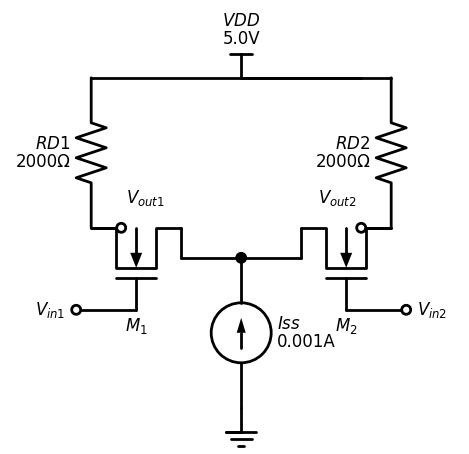

In [14]:
import schemdraw
import schemdraw.elements as elm

# Helper to format labels
def get_label(name, val_key, unit):
    try:
        val = net_dict['instances'][name]['settings'][val_key]
        return f"${name}$\n{val}{unit}"
    except:
        return name

with schemdraw.Drawing() as d:
    d.config(fontsize=12, unit=2.5, inches_per_unit=0.6)

    # 1. Tail Current Source
    d.add(elm.Ground())
    iss = d.add(elm.SourceI().up().label(get_label("Iss", "I", "A"), loc='bottom'))
    source_dot = d.add(elm.Dot())

    # 2. Left Branch (M1)
    d.add(elm.Line().left().length(1).at(source_dot.center))
    d.add(elm.Line().up().length(0.5))
    
    # M1 (flipped vertically with reverse)
    m1 = d.add(elm.NFet(bulk=True).anchor('source').up().reverse().label('$M_1$'))
    
    # RD1
    rd1 = d.add(elm.Resistor().up().at(m1.drain).label(get_label("RD1", "R", "Ω")))

    top_rail = d.add(elm.Line().right().at(rd1.end).length(5)) 
    
    # Add the VDD Symbol at the center of the top rail
    d.add(elm.Vdd().at(top_rail.center).label(get_label("VDD", "V", "V")))
    
    # Top Rail Left Half
    vdd_line_left = d.add(elm.Line().right().length(2)) 
    
    # 3. Right Branch (M2)
    d.add(elm.Line().right().length(1).at(source_dot.center))
    d.add(elm.Line().up().length(0.5))
    
    # M2 (flipped vertically AND horizontally)
    m2 = d.add(elm.NFet(bulk=True).anchor('source').up().reverse().flip().label('$M_2$'))

    # RD2
    rd2 = d.add(elm.Resistor().up().at(m2.drain).label(get_label("RD2", "R", "Ω")))
    
    # Top Rail Right Half & VDD Label
    # FIX: Move VDD label to 'bottom' so it hangs under the wire
    #d.add(elm.Line().to(vdd_line_left.end))
    #d.add(elm.Label().label("VDD", loc='bottom').at(vdd_line_left.end))

    # 4. Inputs (Gates)
    d.add(elm.Line().left().length(1).at(m1.gate))
    d.add(elm.Dot(open=True).label('$V_{in1}$', loc='left'))
    
    d.add(elm.Line().right().length(1).at(m2.gate))
    d.add(elm.Dot(open=True).label('$V_{in2}$', loc='right'))

    # 5. Outputs (Drains)
    # FIX: Use 'ofst' to push labels higher up
    # Left Output
    d.add(elm.Line().right().length(0.5).at(m1.drain))
    d.add(elm.Dot(open=True).label('$V_{out1}$', loc='right', ofst=(0, 0.5)))
    
    # Right Output
    d.add(elm.Line().left().length(0.5).at(m2.drain))
    d.add(elm.Dot(open=True).label('$V_{out2}$', loc='left', ofst=(0, 0.5)))

1. Compiling...
2. Running Sweep (200 points)...
Sweeping DC Operating Point (with Continuation)...
Simulation Time: 0.476s


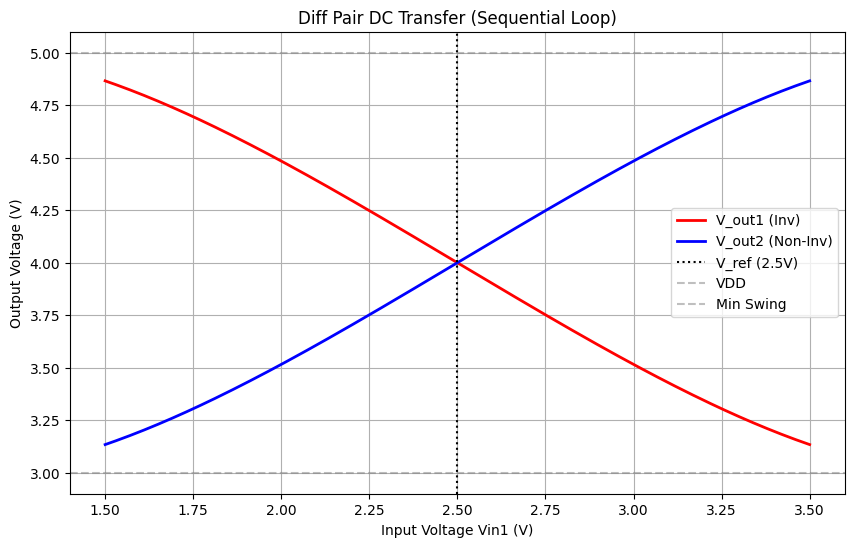

✅ Verification: Outputs look non-zero. Check plot geometry.


In [15]:
def update_param_value(groups, group_name, instance_name, param_key, new_value):
    g = groups[group_name]
    
    instance_idx = g.index_map[instance_name]
    
    batched_comp = g.params
    current_vals = getattr(batched_comp, param_key)
    
    new_vals = current_vals.at[instance_idx].set(new_value)
    
    new_batched_comp = eqx.tree_at(lambda c: getattr(c, param_key), batched_comp, new_vals)
    new_g = eqx.tree_at(lambda g: g.params, g, new_batched_comp)
    
    new_groups = groups.copy()
    new_groups[group_name] = new_g
    return new_groups

jax.config.update("jax_enable_x64", True)

models_map ={
    'nmos': NMOS,
    'resistor': Resistor,
    'source_dc': VoltageSource,
    'current_src': CurrentSource,
    'ground': lambda: 0
}

print("1. Compiling...")
groups, sys_size, port_map = compile_netlist(net_dict, models_map)

linear_strat = KLUSolver.from_circuit(groups, sys_size, is_complex=False)

@jax.jit
def scan_step(y_prev, v_in_val):
    new_groups = update_param_value(groups, 'source_dc', 'Vin1', 'V', v_in_val)
    y_sol = linear_strat.solve_dc(new_groups, y_guess=y_prev)
    return y_sol, y_sol

sweep_voltages = jnp.linspace(1.5, 3.5, 200)

print(f"2. Running Sweep ({len(sweep_voltages)} points)...")
print("Sweeping DC Operating Point (with Continuation)...")
start_time = time.time()

y_current = jnp.zeros(sys_size)
final_y, solutions = jax.lax.scan(scan_step, y_current, sweep_voltages)

total = time.time() - start_time
print(f"Simulation Time: {total:.3f}s")

idx_out1 = port_map["RD1,p2"]
idx_out2 = port_map["RD2,p2"]

v_out1 = solutions[:, idx_out1]
v_out2 = solutions[:, idx_out2]

plt.figure(figsize=(10, 6))
plt.plot(sweep_voltages, v_out1, 'r-', linewidth=2, label='V_out1 (Inv)')
plt.plot(sweep_voltages, v_out2, 'b-', linewidth=2, label='V_out2 (Non-Inv)')

plt.axvline(2.5, color='k', linestyle=':', label='V_ref (2.5V)')
plt.axhline(5.0, color='gray', linestyle='--', alpha=0.5, label='VDD')
plt.axhline(5.0 - (1e-3 * 2000), color='gray', linestyle='--', alpha=0.5, label='Min Swing')

plt.title("Diff Pair DC Transfer (Sequential Loop)")
plt.xlabel("Input Voltage Vin1 (V)")
plt.ylabel("Output Voltage (V)")
plt.legend()
plt.grid(True)
plt.show()

if jnp.all(v_out1 == 0):
    print("❌ ERROR: Output is all zeros. Solver did not converge or model is broken.")
else:
    print("✅ Verification: Outputs look non-zero. Check plot geometry.")